In [1]:
!pip install dimod
!pip install 'qiskit[all]'
!pip install dwave-neal

ERROR: Invalid requirement: "'qiskit[all]'"


In [2]:
!pip install matplotlib==3.1.3

  Using cached matplotlib-3.1.3-cp38-cp38-win_amd64.whl (9.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.2
    Uninstalling matplotlib-3.3.2:
      Successfully uninstalled matplotlib-3.3.2


In [3]:
!pip install plotly

  Using cached plotly-5.3.1-py2.py3-none-any.whl (23.9 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from time import time
from pprint import pprint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output

In [3]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from dimod import BinaryQuadraticModel, AdjVectorBQM
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import LinearEqualityToPenalty, InequalityToEquality, IntegerToBinary
import neal

In [4]:
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, ADAM
from qiskit.optimization import QuadraticProgram
from docplex.mp.model import Model

from qiskit.optimization.applications.ising import stable_set
from qiskit import Aer
from qiskit.optimization.applications.ising import stable_set
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA, NumPyEigensolver
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

NodeView((1, 2, 3, 4, 5))

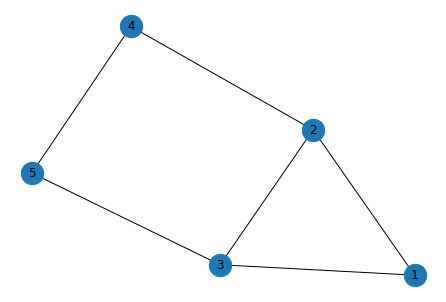

In [6]:
G1 = nx.Graph([(1,2),(1,3),(2,3),(2,4),(4,5),(5,3)])
# G1 = nx.Graph()
# G1_edges_list = [(1,2), (2,3)]
# G1.add_node(0)
# G1_nodes_list = [0,1,2,3]
# G1.add_edges_from(G1_edges_list)
# G1.add_nodes_from(G1_nodes_list)
nx.draw(G1, with_labels=True, alpha=1, node_size=500)
G1.nodes

True

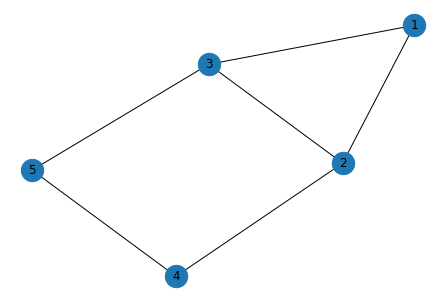

In [7]:
G2 = nx.Graph([(1,2),(1,3),(2,3),(2,4),(4,5),(5,3)])
# G2 = nx.Graph()
# G2_edges_list = [(0,3), (3,1)]
# G2.add_node(2)
# G2_nodes_list = [0,1,2,3]
# G2.add_edges_from(G2_edges_list)
# G2.add_nodes_from(G2_nodes_list)
nx.draw(G2, with_labels=True, alpha=1, node_size=500)
G2.nodes
nx.is_isomorphic(G1,G2)

In [8]:
def add_variables(qp, G1, G2):
    for u in G1.nodes:
        for i in G2.nodes:
            qp.binary_var(f"x_{u}_{i}")


def one_node_connectG1(qp, G1, G2):
    
    for u in G2.nodes:
        L = {}
        for i in G1.nodes:
            L[f"x_{u}_{i}"] = 1
        qp.linear_constraint(linear = L, sense='E', rhs=1)


def one_node_connectG2(qp, G1, G2):
    for i in G1.nodes:
        L = {}
        for u in G2.nodes:
            
            L[f"x_{u}_{i}"] = 1
        qp.linear_constraint(linear = L, sense='E', rhs=1)


def get_objective(qp):
    qdict = {}
    for key, item in qp.variables_index.items():
        qdict[item] = key

    qp.objective.quadratic.to_dict()
    Q_int = qp.objective.quadratic.to_dict()
    L_int = qp.objective.linear.to_dict()
    
    Q = defaultdict(lambda: 0) 
    for k, v in Q_int.items():
        k1 = k[0]
        k2 = k[1]
        Q[(qdict[k1], qdict[k2])] = v
    
    L = defaultdict(lambda: 0)
    for k, v in L_int.items():
        L[qdict[k]] = v

    C = qp.objective.constant
    return Q, L, C


def not_in_edges1(qp, G1, G2, C2):

    Q, L, C = get_objective(qp)

#     for i,j in itertools.product(G1.nodes, G1.nodes): #original
    for i,j in itertools.combinations(G1.nodes, 2):

        if (i,j) not in G1.edges and i != j:
            
            
            for u,v in itertools.combinations(G2.nodes, 2):# original
            # for u,v in itertools.combinations(G2.nodes, 2):
                if (u,v) in G2.edges:
#                     print(i,j,u,v)
                    Q[(f"x_{u}_{i}", f"x_{v}_{j}")] = C2*0
    
    qp.minimize(quadratic = Q, linear = L, constant = C)


def not_in_edges2(qp, G1, G2, C2):

    Q, L, C = get_objective(qp)
    
#     for i,j in itertools.product(G1.nodes, G1.nodes): #original
        
        
    for i,j in itertools.combinations(G1.nodes, 2):
        
        if (i,j) in G1.edges:
            
            for u,v in itertools.combinations(G2.nodes, 2): #original
            # for u,v in itertools.combinations(G2.nodes, 2):
                
                if (u,v) not in G2.edges and u != v:
#                     print(i,j,u,v)
                    Q[(f"x_{u}_{i}", f"x_{v}_{j}")] = C2*0
    
    qp.minimize(quadratic = Q, linear = L, constant = C)

In [9]:
import dimod
from dimod import BinaryQuadraticModel, AdjVectorBQM

qp = QuadraticProgram()
ineq2eq = InequalityToEquality()
int2bin = IntegerToBinary()

C1 = 1
C2 = 1

# print('Ration of: ', C2/C1)

add_variables(qp, G1, G2)

one_node_connectG1(qp, G1, G2)
lineq2penalty = LinearEqualityToPenalty(penalty=C1)
qp = lineq2penalty.convert(int2bin.convert(ineq2eq.convert(qp)))

In [ ]:
from qiskit.optimization.converters import QuadraticProgramToQubo

one_node_connectG2(qp, G1, G2)
lineq2penalty = LinearEqualityToPenalty(penalty=C1)
qp = lineq2penalty.convert(int2bin.convert(ineq2eq.convert(qp)))
not_in_edges1(qp, G1, G2, C2)
not_in_edges2(qp, G1, G2, C2)

conv = QuadraticProgramToQubo()
prob = conv.convert(qp)
Hamiltonian  = prob.to_ising()[0]
variables = prob.variables_index
true_result = NumPyEigensolver(operator = Hamiltonian).run().eigenvalues

C:\Users\ASUS\anaconda3\envs\base1\lib\site-packages\qiskit\aqua\operators\operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')
C:\Users\ASUS\anaconda3\envs\base1\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


In [ ]:
true_result

In [53]:
optmizer = ADAM(maxiter = 100)
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_solve = QAOA(Hamiltonian, optimizer = optmizer, p = 1, quantum_instance  = quantum_instance)

In [54]:
# qaoa_solve.cleanup_parameterized_circuits
initial_angle = np.random.random(2)
# x = qaoa_solve.construct_circuit(initial_angle)

In [55]:
qaoa_solve.run()

{'optimal_parameters': {ParameterVectorElement(θ[0]): 0.4178136349783352, ParameterVectorElement(θ[1]): 0.8860348069280014}, 'optimal_point': array([0.41781363, 0.88603481]), 'optimal_value': -73.333984375, 'optimizer_evals': 100, 'optimizer_time': 9783.31620168686, 'eigenvalue': (-73.333984375+0j), 'eigenstate': {'1101100000000001001000000': 1, '1010100000011110010011111': 1, '1101100001000010101110010': 1, '0100100000100001000100000': 1, '0000111010011001101000000': 1, '1101101111011100110001000': 1, '1111100000000100000000000': 1, '0000000000000000001011111': 2, '0000010001101101111000000': 1, '1101101000100000100000000': 1, '0101100000110011111100000': 1, '0000000000001101111011001': 1, '1110100000100100010011101': 1, '1101000000000001111100000': 1, '1010000001001100010000000': 1, '0000011011000001110110111': 1, '1001000010000000000010011': 1, '0000011111001110000000000': 1, '0000011110000001000100000': 1, '0011010111000001110100000': 1, '1001010000100001100000110': 1, '10110000001

In [28]:
Q_mat = AdjVectorBQM(qp.objective.linear.to_dict(), qp.objective.quadratic.to_dict(), 
                      qp.objective.constant, vartype='BINARY').to_numpy_matrix()

Q, offset = AdjVectorBQM(qp.objective.linear.to_dict(), qp.objective.quadratic.to_dict(), 
                      qp.objective.constant, vartype='BINARY').to_qubo()

In [29]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# matprint(Q_mat)
for i in range(len(Q_mat)):
    print(Q_mat[i])

[-2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  0.  0.
  0.  0.  2.  0.  0.  0.  0.]
[ 0. -2.  2.  2.  2.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  0.
  0.  0.  0.  2.  0.  0.  0.]
[ 0.  0. -2.  2.  2.  0.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.
  0.  0.  0.  0.  2.  0.  0.]
[ 0.  0.  0. -2.  2.  0.  0.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.
  2.  0.  0.  0.  0.  2.  0.]
[ 0.  0.  0.  0. -2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.
  0.  2.  0.  0.  0.  0.  2.]
[ 0.  0.  0.  0.  0. -2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  2.  0.  0.
  0.  0.  2.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0. -2.  2.  2.  2.  0.  2.  0.  0.  0.  0.  2.  0.
  0.  0.  0.  2.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0. -2.  2.  2.  0.  0.  2.  0.  0.  0.  0.  2.
  0.  0.  0.  0.  2.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  0.  0.  0.  2.  0.  0.  0.  0.
  2.  0.  0.  0.  0.  2.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0.  0.  2.  0.  0.  0.


In [30]:
print('offset:', offset)

s = neal.SimulatedAnnealingSampler()
sampleset = s.sample_qubo(Q, beta_range=(5, 100), num_sweeps=20000, num_reads=100,
                        beta_schedule_type='geometric')


energies = []
for datum in sampleset.data(fields=["sample", "energy"]):
    energies.append(datum.energy)

print(offset)
print(energies+offset)
# print(Q_mat)

offset: 10.0
10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 4. 4. 4. 4.]


In [31]:
qubitOp, offset = stable_set.get_operator(Q_mat)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

# mapping Ising Hamiltonian to Quadratic Program
qp1 = QuadraticProgram()
qp1.from_ising(qubitOp, offset)
qp1.to_docplex().prettyprint()


aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

qaoa = QAOA(quantum_instance=quantum_instance, p = 1)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
result = qaoa_optimizer.solve(qp)

Offset: 37.5
Ising Hamiltonian:
IIIIIIIIIIIIIIIIIIIIIIIZZ	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIIIZIZ	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIIZIIZ	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIZIIIZ	(0.5+0j)
IIIIIIIIIIIIIIIIIIIZIIIIZ	(0.5+0j)
IIIIIIIIIIIIIIZIIIIIIIIIZ	(0.5+0j)
IIIIIIIIIZIIIIIIIIIIIIIIZ	(0.5+0j)
IIIIZIIIIIIIIIIIIIIIIIIIZ	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIIIZZI	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIIZIZI	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIZIIZI	(0.5+0j)
IIIIIIIIIIIIIIIIIIZIIIIZI	(0.5+0j)
IIIIIIIIIIIIIZIIIIIIIIIZI	(0.5+0j)
IIIIIIIIZIIIIIIIIIIIIIIZI	(0.5+0j)
IIIZIIIIIIIIIIIIIIIIIIIZI	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIIZZII	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIZIZII	(0.5+0j)
IIIIIIIIIIIIIIIIIZIIIIZII	(0.5+0j)
IIIIIIIIIIIIZIIIIIIIIIZII	(0.5+0j)
IIIIIIIZIIIIIIIIIIIIIIZII	(0.5+0j)
IIZIIIIIIIIIIIIIIIIIIIZII	(0.5+0j)
IIIIIIIIIIIIIIIIIIIIZZIII	(0.5+0j)
IIIIIIIIIIIIIIIIZIIIIZIII	(0.5+0j)
IIIIIIIIIIIZIIIIIIIIIZIII	(0.5+0j)
IIIIIIZIIIIIIIIIIIIIIZIII	(0.5+0j)
IZIIIIIIIIIIIIIIIIIIIZIII	(0.5+0j)
IIIIIIIIIIIIIIIZIIIIZIIII	(0.5+0j)
IIIIIIIIIIZIIIIIIIIIZII

In [15]:
print(result)

optimal function value: 0.0
optimal value: [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
status: SUCCESS


In [ ]:
offset